# Machine Learning Project to Predict Stock Market Activity
*Created by Jordan Rust and Jenelle Dobyns*

## Introduction

The goal of this project is to be able to predict the future value of a company's stock. This is a difficult task, as predicting how the stock market will perform involves many factors. The share prices are dynamic and volatile, meaning the predictions will be difficult to make with high accuracy.

## Methods

To accomplish this, we will create a Long Short Term Memory Network (LSTM). This is a recurrent neural network for learning long-term dependencies, commonly used for predicting time-series data.

For the purpose of this assignment, we will use technical analysis to determine how stocks may change. This means measurable data from stock market activities (stock prices, returns, volume of trades, etc.). This data is relatively short-termed and affected by current events, so the accuracy of our predictions will decrease the further in the future we go.

### The Dataset

Predicting the stock market requires a focused approach, so the first step will be looking into one company at a time.

Microsoft has been public since 1986 to 3/23/2022, meaning there is a lot of data that we can use to train our algorithm with. We have a CSV file with the following information on it

| Term       | Description |
| :----------- | :-----------  |
| Date        | Day market was open          |
| Open        | Price from the first transaction of a trading day | 
| High        | Maximum price in a trading day        |
| Low        | Minimum price in a trading day        |
| Close        | Price from the last transaction of a trading day        |
| Adjacent Close  | Closing price adjusted     |
| Volume        | Number of units traded in a day   |

### The Process

First we need to get the data into a workable state. From there we create our model and fit our data to the model. Once it is trained, we can determine how accurate our predictions are to the real data

To determine if our predictions were as good as we could make them, we will also be using a few other models to compare which is the most accurate. We will test with Random Forest, Support Vector Machine (SVM), K-nearest neighbor, and Naive Bayesian.

To determine the ranking of models, we will use Root Mean Square Deviation (RMSE) and Mean Absolute Percentage Error (MAPE). For both of these measurements, we want to have lower values.



In [ ]:
#Importing the Libraries
import pandas as pd                  
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [ ]:
#Get the Dataset
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df['1990']

<ipython-input-6-f269b0c53dba>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['1990']


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.389448,53035200
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.391642,113774400
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.403161,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.393288,69566400
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.399321,58982400
...,...,...,...,...,...,...
1990-12-24,1.048611,1.048611,1.038194,1.045139,0.660416,13550400
1990-12-26,1.045139,1.052083,1.034722,1.041667,0.658222,16214400
1990-12-27,1.041667,1.045139,1.034722,1.038194,0.656028,22629600


Now we want to check our data for any irregularities, in this case checking for any Null values. Above we made our DataFrame set any NA values to Null, so we want to check if we have any of these. If we do have Null values, it will alter our results, as they are viewed as Outliers 

In [ ]:
#Check for Null values
#Start with looking at the shape of the DataFrame
print("Shape: ", df.shape)
#See if we have any null values present
print("Are there Null: ", df.isnull().values.any())

Shape:  (9083, 6)
Are there Null:  False


Ok, the data looks good to go through with the calculations. No Null values 

We are most interested in Adj Close, the closing price on that market day for the stock. We will be using this to determine how accurate our model is

<Axes: xlabel='Date'>

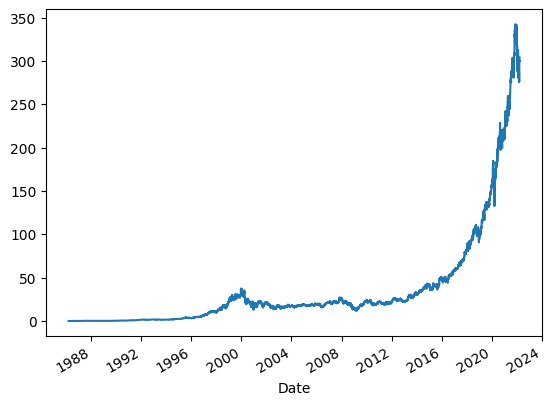

In [ ]:
df['Adj Close'].plot()

Now we have the data in a form we can use. Now we need to find the target variables and features to use

We have the following to use for training:
- Open
- High
- Low
- Volume

In [ ]:
#Target Variable (aka dependent variable)
output = pd.DataFrame(df['Adj Close'])

features = ['Open', 'High', 'Low', 'Close']

#### There is a lot of data to go through, so to reduce the workload we can scale the data down. We can use MinMaxScaler from sklearn to do this. This is done by the following process [1]

*X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))*

*X_scaled = X_std * (max - min) + min*

#### We are going to reduce our values from above into a range of 0 -> 1


In [ ]:
#Scale down data to reduce computer workload
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)

Here was what the old values looked like:

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,295.369995,301.000000,292.730011,300.429993,300.429993,43317000
2022-03-21,298.890015,300.140015,294.899994,299.160004,299.160004,28351200
2022-03-22,299.799988,305.000000,298.769989,304.059998,304.059998,27599700
2022-03-23,300.510010,303.230011,297.720001,299.489990,299.489990,25715400
2022-03-24,299.140015,304.200012,298.320007,304.100006,304.100006,24446900


And here are the new scaled down values



In [ ]:
feature_transform.head()

,Open,High,Low,Close
Date,,,,
1986-03-13,0.000000,0.000027,0.000000,0.000020
1986-03-14,0.000025,0.000030,0.000025,0.000030
1986-03-17,0.000035,0.000032,0.000036,0.000035
1986-03-18,0.000040,0.000032,0.000030,0.000028
1986-03-19,0.000033,0.000025,0.000025,0.000023


In [ ]:
feature_transform.tail()

,Open,High,Low,Close
Date,,,,
2022-03-18,0.857052,0.860775,0.855398,0.875576
2022-03-21,0.867269,0.858315,0.861741,0.871873
2022-03-22,0.869910,0.872217,0.873053,0.886158
2022-03-23,0.871971,0.867154,0.869984,0.872835
2022-03-24,0.867995,0.869929,0.871738,0.886275


Now that the data is in a state we can work with, we are going to split it into train and test sets. We can use TimeSeriesSplit since our data is time series. "Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets" [2]

In [ ]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output[:len(train_index)].values.ravel(), output[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print("Xtrain shape: ",X_train.shape)
print("Xtest shape: ",X_test.shape)
print("ytrain shape: ",y_train.shape)
print("ytest shape: ",y_test.shape)

Xtrain shape:  (8258, 4)
Xtest shape:  (825, 4)
ytrain shape:  (8258,)
ytest shape:  (825,)


In [ ]:
#Data processing for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
print("Xtrain shape: ",trainX.shape)
print("Xtest shape: ",X_test.shape)
print("ytrain shape: ",y_train.shape)
print("ytest shape: ",y_test.shape)

Xtrain shape:  (8258, 4)
Xtest shape:  (825, 1, 4)
ytrain shape:  (8258,)
ytest shape:  (825,)


We can create the LSTM and plot the model from keras and plot_model to give a visual representation [3]

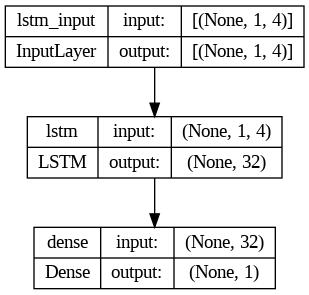

In [ ]:
#Build the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

Now that the model is made all we need to do is train it with the data

In [ ]:
#Train the LSTM Model
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
1033/1033 [==============================] - 6s 4ms/step - loss: 48.1549
Epoch 2/100
1033/1033 [==============================] - 3s 3ms/step - loss: 175.7045
Epoch 3/100
1033/1033 [==============================] - 4s 4ms/step - loss: 92.2367
Epoch 4/100
1033/1033 [==============================] - 4s 4ms/step - loss: 53.6974
Epoch 5/100
1033/1033 [==============================] - 3s 3ms/step - loss: 30.1461
Epoch 6/100
1033/1033 [==============================] - 3s 3ms/step - loss: 16.2263
Epoch 7/100
1033/1033 [==============================] - 5s 5ms/step - loss: 8.6953
Epoch 8/100
1033/1033 [==============================] - 4s 4ms/step - loss: 5.0680
Epoch 9/100
1033/1033 [==============================] - 4s 3ms/step - loss: 3.3395
Epoch 10/100
1033/1033 [==============================] - 3s 3ms/step - loss: 2.4800
Epoch 11/100
1033/1033 [==============================] - 5s 5ms/step - loss: 2.0427
Epoch 12/100
1033/1033 [==============================] - 4s 4ms/st

The model is trained and ready for predictions

In [ ]:
#Make the LSTM Prediction
y_pred= lstm.predict(X_test)
errors = abs(y_pred - y_test)

26/26 [==============================] - 0s 2ms/step


We want to see how well our prediction compared to our actual values

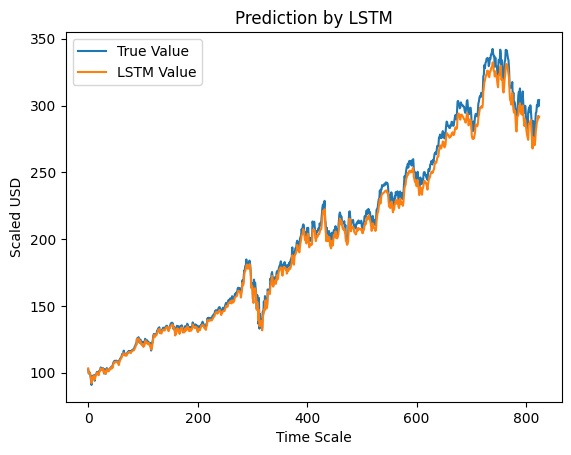

In [ ]:
#Compare predicted values to true adjusted close value
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

Based on the graph above, it seems the model made fairly accurate predictions. As mentioned, the accuracy will decrease the longer out the predictions are.

Let's take a look at this data through the lens of cross-correlations

In [ ]:
import statsmodels.api as sm

In [ ]:
#calculate cross correlation
test = sm.tsa.stattools.ccf(y_test, y_pred, adjusted=False)

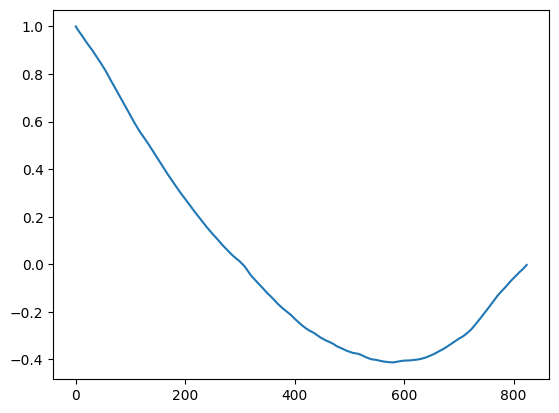

In [ ]:
plt.plot(test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we can see our model has high correlation at the beginning, which slowly goes down with time. In other words, the predictions become less accurate. Notice around the 600 mark in the graph 1 we have more deviation from the true values, this can be seen in graph 2.

However, at a certain point the correlation goes up. It still is only 0 at the end.

## How do other models compare?



### Random Forest

In [ ]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output[:len(train_index)].values.ravel(), output[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print("Xtrain shape: ",X_train.shape)
print("Xtest shape: ",X_test.shape)
print("ytrain shape: ",y_train.shape)
print("ytest shape: ",y_test.shape)

Xtrain shape:  (8258, 4)
Xtest shape:  (825, 4)
ytrain shape:  (8258,)
ytest shape:  (825,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 100)

In [ ]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=100)

In [ ]:
predictions = rf.predict(X_test)
errors = abs(predictions - y_test)

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 61.21 %.


Not a good accuracy, not compared to our original LSTM model

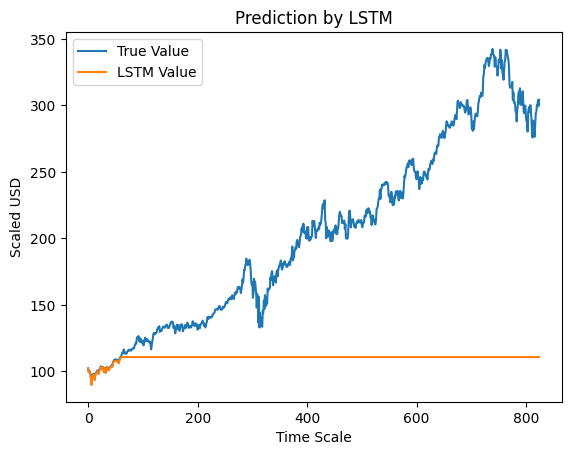

In [ ]:
#Compare predicted values to true adjusted close value
plt.plot(y_test, label='True Value')
plt.plot(predictions, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

This is a result of random forest being a poor choice as the Random Forest Regressor is unable to discover trends that would enable it in extrpolating values that fall outside the training set [4]

In [ ]:
#calculate cross correlation
test = sm.tsa.stattools.ccf(y_test, predictions, adjusted=False)

### Conclusions

The Long Short-Term Memory model that we developed is semi functional at predicting stock changes and is mostly accurate with the true data. 

### References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

[3] https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

[4] https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why